In [2]:
import pandas as pd
import numpy as np
import pickle
import os
import ruptures as rpt
from tqdm import tqdm
import gc

# =====================================================
# CONFIGURATION
# =====================================================

RAW_DATA_FILE = '/home/jupyter-yin10/EEG_HAR/Pipeline_experiments/data/combined_all.csv'
OUTPUT_DIR = '/home/jupyter-yin10/EEG_HAR/Pipeline_experiments/data/windowed_zscore_temporal5fold_75overlap'

os.makedirs(OUTPUT_DIR, exist_ok=True)

# Reference activity for differential overlap
REFERENCE_ACTIVITY = 4

# CPD parameters
FS = 125
CPD_MODEL = 'l2'
CPD_MIN_SIZE = int(4 * FS)
CPD_JUMP = 5
CPD_PEN = 10

# Windowing parameters
WINDOW_SIZE = 4
WINDOW_SAMPLES = int(WINDOW_SIZE * FS)

# Cross-validation
N_FOLDS = 5
ACCEPTABLE_RANGE = (0.18, 0.22)  # ENFORCED

# Differential overlap configuration
POS_OVERLAP = 0.75
NEG_OVERLAP = 0.0
VAL_OVERLAP = 0.0

print("="*70)
print("PIPELINE: RAW DATA → Z-Score Normalization → CPD → 5-FOLD (FULL ENFORCEMENT) → WINDOWING")
print("="*70)

print(f"\nConfiguration:")
print(f"  Reference Activity: {REFERENCE_ACTIVITY}")
print(f"  CPD: model={CPD_MODEL}, min_size={CPD_MIN_SIZE} samples (4s)")
print(f"  Window: {WINDOW_SIZE}s ({WINDOW_SAMPLES} samples)")
print(f"  CV: {N_FOLDS}-fold temporal split")
print(f"  Test range: {ACCEPTABLE_RANGE[0]*100:.0f}%-{ACCEPTABLE_RANGE[1]*100:.0f}% (FULL ENFORCEMENT)")

# =====================================================
# HELPER FUNCTIONS
# =====================================================

def detect_change_points(data, min_size, pen, jump):
    """Detect change points using Pelt algorithm with L2 cost."""
    signal_variance = np.var(data, axis=1)
    algo = rpt.Pelt(model='l2', min_size=min_size, jump=jump)
    algo.fit(signal_variance.reshape(-1, 1))
    breakpoints = algo.predict(pen=pen)
    return breakpoints


def create_windows_from_segment(segment, window_size, overlap):
    """Create windows from ONE segment with specified overlap."""
    n_samples, n_channels = segment.shape
    stride = int(window_size * (1 - overlap))
    
    windows = []
    start = 0
    
    while start + window_size <= n_samples:
        window = segment[start:start + window_size, :]
        windows.append(window)
        start += stride
    
    return np.array(windows) if len(windows) > 0 else np.array([]).reshape(0, window_size, n_channels)


def select_test_segments_full_enforcement(segments, fold, n_folds, 
                                         acceptable_range=(0.18, 0.22)):
    """
    FULL ENFORCEMENT: Guarantees test percentage within acceptable_range.
    
    Strategy:
    1. Build test set greedily within temporal window
    2. If next segment would exceed upper limit (22%), make it BUFFER
    3. Train starts after buffer
    4. For Fold 5, also check if we need buffer at the END of train
    """
    total_duration = sum(seg['duration_sec'] for seg in segments)
    
    # Calculate temporal range for this fold
    start_pct = (fold - 1) / n_folds
    end_pct = fold / n_folds
    target_start_time = total_duration * start_pct
    target_end_time = total_duration * end_pct
    
    # Build test set greedily
    test_indices = []
    test_duration = 0
    buffer_indices = []
    
    cumulative_time = 0
    for idx, seg in enumerate(segments):
        seg_start = cumulative_time
        seg_end = cumulative_time + seg['duration_sec']
        
        # Check if this segment overlaps with temporal window
        if seg_end > target_start_time and seg_start < target_end_time:
            # Try adding this segment to test
            new_test_duration = test_duration + seg['duration_sec']
            new_test_pct = new_test_duration / total_duration
            
            if new_test_pct <= acceptable_range[1]:  # Within upper limit (22%)
                # Add to test
                test_indices.append(idx)
                test_duration = new_test_duration
            else:
                # Would exceed 22% - make this segment a BUFFER
                buffer_indices.append(idx)
                break  # Stop building test set
        
        cumulative_time = seg_end
    
    # Check if test set is within acceptable range
    final_test_pct = test_duration / total_duration if total_duration > 0 else 0
    
    if final_test_pct < acceptable_range[0]:  # Below 18%
        # Try to add the buffer back to test if it exists
        if len(buffer_indices) > 0:
            buffer_seg = buffer_indices[0]
            new_test_duration = test_duration + segments[buffer_seg]['duration_sec']
            new_test_pct = new_test_duration / total_duration
            
            # Check which is closer to acceptable range
            dist_without = acceptable_range[0] - final_test_pct  # How far below 18%
            dist_with = new_test_pct - acceptable_range[1] if new_test_pct > acceptable_range[1] else 0  # How far above 22%
            
            if dist_with <= dist_without:  # Adding buffer is better
                test_indices.append(buffer_seg)
                test_duration = new_test_duration
                buffer_indices = []
                final_test_pct = new_test_pct
    
    # Train is everything not in test or buffer
    train_indices = [i for i in range(len(segments)) 
                    if i not in test_indices and i not in buffer_indices]
    
    # For Fold 5 (test at end), check if we need buffer at END of train
    if fold == n_folds and len(train_indices) > 0 and len(test_indices) > 0:
        max_train = max(train_indices)
        min_test = min(test_indices)
        
        if max_train + 1 == min_test and len(buffer_indices) == 0:
            # Adjacent! Make last train segment a buffer
            # Check if this keeps test in range
            test_pct_current = test_duration / total_duration
            
            if test_pct_current >= acceptable_range[0]:  # Still above 18%
                train_indices.remove(max_train)
                buffer_indices.append(max_train)
    
    # Calculate final percentages
    test_duration = sum(segments[i]['duration_sec'] for i in test_indices)
    train_duration = sum(segments[i]['duration_sec'] for i in train_indices)
    buffer_duration = sum(segments[i]['duration_sec'] for i in buffer_indices)
    
    actual_test_pct = test_duration / total_duration if total_duration > 0 else 0
    actual_train_pct = train_duration / total_duration if total_duration > 0 else 0
    actual_buffer_pct = buffer_duration / total_duration if total_duration > 0 else 0
    
    buffer_applied = len(buffer_indices) > 0
    
    return test_indices, train_indices, buffer_indices, actual_test_pct, actual_train_pct, actual_buffer_pct, buffer_applied


def create_windows_for_fold_differential(fold, segments_by_recording, fold_info_df, 
                                         reference_activity, pos_overlap, neg_overlap, val_overlap):
    """Create windows with DIFFERENTIAL overlap."""
    train_windows = []
    train_labels = []
    val_windows = []
    val_labels = []
    
    fold_recordings = fold_info_df[fold_info_df['fold'] == fold]
    
    for _, rec_fold_info in fold_recordings.iterrows():
        rec_id = rec_fold_info['recording_id']
        recording_segments = segments_by_recording[rec_id]
        
        # TRAIN SEGMENTS
        for seg_idx in rec_fold_info['train_segment_indices']:
            segment = recording_segments[seg_idx]
            label = segment['activity_id']
            
            if label == reference_activity:
                overlap = pos_overlap
            else:
                overlap = neg_overlap
            
            windows = create_windows_from_segment(segment['segment_data'], WINDOW_SAMPLES, overlap)
            
            if len(windows) > 0:
                train_windows.extend(windows)
                train_labels.extend([label] * len(windows))
        
        # VAL SEGMENTS
        for seg_idx in rec_fold_info['test_segment_indices']:
            segment = recording_segments[seg_idx]
            label = segment['activity_id']
            
            windows = create_windows_from_segment(segment['segment_data'], WINDOW_SAMPLES, val_overlap)
            
            if len(windows) > 0:
                val_windows.extend(windows)
                val_labels.extend([label] * len(windows))
    
    return np.array(train_windows), np.array(train_labels), np.array(val_windows), np.array(val_labels)

# =====================================================
# STEP 1: LOAD RAW DATA
# =====================================================

print(f"\n" + "="*70)
print("STEP 1: LOAD RAW DATA AND CREATE RECORDINGS")
print("="*70)

df = pd.read_csv(RAW_DATA_FILE)
print(f"✓ Loaded {len(df)} rows")

eeg_columns = [f'ch{i}' for i in range(1, 17)]

grouped = df.groupby(['subject', 'activity_id', 'activity_label'])

raw_recordings = []

for (subject, activity_id, activity_label), group in tqdm(grouped, desc="Creating recordings"):
    eeg_data = group[eeg_columns].values
    duration_sec = len(eeg_data) / FS
    
    raw_recordings.append({
        'subject': subject,
        'activity_id': activity_id,
        'activity_label': activity_label,
        'data': eeg_data,
        'duration_sec': duration_sec
    })

print(f"\n✓ Created {len(raw_recordings)} raw recordings")

subjects_in_data = sorted(list(set([item['subject'] for item in raw_recordings])))
activities_in_data = sorted(list(set([item['activity_id'] for item in raw_recordings])))
print(f"  Subjects: {subjects_in_data}")
print(f"  Activities: {activities_in_data}")

total_dataset_duration = sum(item['duration_sec'] for item in raw_recordings)
print(f"\nDataset statistics:")
print(f"  Total duration: {total_dataset_duration:.1f}s ({total_dataset_duration/60:.1f} min)")

# =====================================================
# STEP 1.5: Z-SCORE NORMALIZATION
# =====================================================

print(f"\n" + "="*70)
print("STEP 1.5: Z-SCORE NORMALIZATION")
print("="*70)

for recording in tqdm(raw_recordings, desc="Normalizing"):
    data = recording['data']  # Shape: (n_samples, 16)
    
    # Z-score normalize per channel (across time)
    mean_per_channel = np.mean(data, axis=0, keepdims=True)  # (1, 16)
    std_per_channel = np.std(data, axis=0, keepdims=True) + 1e-8  # (1, 16)
    
    normalized_data = (data - mean_per_channel) / std_per_channel
    
    # Replace raw data with normalized data
    recording['data'] = normalized_data

print(f"✓ Normalized {len(raw_recordings)} recordings (z-score per channel)")

# =====================================================
# STEP 2: CHANGE POINT DETECTION
# =====================================================

print(f"\n" + "="*70)
print("STEP 2: CHANGE POINT DETECTION")
print("="*70)

all_segments = []
segment_counter = 0

for rec_idx, recording in enumerate(tqdm(raw_recordings, desc="Running CPD")):
    subject = recording['subject']
    activity_id = recording['activity_id']
    activity_label = recording['activity_label']
    data = recording['data']
    
    try:
        breakpoints = detect_change_points(data, CPD_MIN_SIZE, CPD_PEN, CPD_JUMP)
        
        start = 0
        for end in breakpoints:
            segment_data = data[start:end, :]
            segment_duration = (end - start) / FS
            
            all_segments.append({
                'segment_id': segment_counter,
                'recording_id': rec_idx,
                'subject': subject,
                'activity_id': activity_id,
                'activity_label': activity_label,
                'segment_data': segment_data,
                'n_samples': end - start,
                'duration_sec': segment_duration,
                'start_time_in_recording': start / FS
            })
            segment_counter += 1
            start = end
        
    except Exception as e:
        print(f"\n✗ CPD failed for {subject}, Activity {activity_id}: {e}")
        continue

print(f"\n✓ Created {len(all_segments)} segments across {len(raw_recordings)} recordings")

segments_df = pd.DataFrame([
    {k: v for k, v in seg.items() if k != 'segment_data'}
    for seg in all_segments
])

print(f"\nSegment summary:")
print(f"  Total segments: {len(segments_df)}")
print(f"  Mean duration: {segments_df['duration_sec'].mean():.1f}s ± {segments_df['duration_sec'].std():.1f}s")
print(f"  Min duration: {segments_df['duration_sec'].min():.1f}s")
print(f"  Max duration: {segments_df['duration_sec'].max():.1f}s")

segments_metadata_file = os.path.join(OUTPUT_DIR, 'segments_metadata.csv')
segments_df.to_csv(segments_metadata_file, index=False)
print(f"\n✓ Saved segments metadata")

# =====================================================
# STEP 3: TEMPORAL 5-FOLD WITH FULL ENFORCEMENT
# =====================================================

print(f"\n" + "="*70)
print("STEP 3: TEMPORAL 5-FOLD SPLIT (FULL ENFORCEMENT)")
print("="*70)

segments_by_recording = {}
for seg in all_segments:
    rec_id = seg['recording_id']
    if rec_id not in segments_by_recording:
        segments_by_recording[rec_id] = []
    segments_by_recording[rec_id].append(seg)

fold_info_per_recording = []
total_buffer_segments = 0

for rec_id in range(len(raw_recordings)):
    recording_segments = segments_by_recording.get(rec_id, [])
    
    if len(recording_segments) == 0:
        continue
    
    recording = raw_recordings[rec_id]
    
    for fold in range(1, N_FOLDS + 1):
        test_indices, train_indices, buffer_indices, test_pct, train_pct, buffer_pct, buffer_applied = \
            select_test_segments_full_enforcement(
                recording_segments,
                fold,
                N_FOLDS,
                acceptable_range=ACCEPTABLE_RANGE
            )
        
        total_buffer_segments += len(buffer_indices)
        
        fold_info_per_recording.append({
            'recording_id': rec_id,
            'subject': recording['subject'],
            'activity_id': recording['activity_id'],
            'activity_label': recording['activity_label'],
            'fold': fold,
            'test_segment_indices': test_indices,
            'train_segment_indices': train_indices,
            'buffer_segment_indices': buffer_indices,
            'buffer_applied': buffer_applied,
            'n_test_segments': len(test_indices),
            'n_train_segments': len(train_indices),
            'n_buffer_segments': len(buffer_indices),
            'test_duration': sum(recording_segments[i]['duration_sec'] for i in test_indices),
            'train_duration': sum(recording_segments[i]['duration_sec'] for i in train_indices),
            'buffer_duration': sum(recording_segments[i]['duration_sec'] for i in buffer_indices),
            'recording_duration': recording['duration_sec'],
            'test_pct': test_pct * 100,
            'train_pct': train_pct * 100,
            'buffer_pct': buffer_pct * 100
        })

fold_info_df = pd.DataFrame(fold_info_per_recording)

print(f"\n✓ Created {N_FOLDS}-fold split for {len(raw_recordings)} recordings")
print(f"✓ Total buffer segments: {total_buffer_segments}")

print(f"\nPer-recording percentages:")
for fold in range(1, N_FOLDS + 1):
    fold_data = fold_info_df[fold_info_df['fold'] == fold]
    mean_test = fold_data['test_pct'].mean()
    mean_train = fold_data['train_pct'].mean()
    mean_buffer = fold_data['buffer_pct'].mean()
    n_buffers = fold_data['n_buffer_segments'].sum()
    
    print(f"  Fold {fold}: Train={mean_train:.1f}%, Test={mean_test:.1f}%, Buffer={mean_buffer:.1f}% ({n_buffers} segments)")

# Verify GLOBAL percentages
print(f"\nGLOBAL percentages (MUST be within {ACCEPTABLE_RANGE[0]*100:.0f}%-{ACCEPTABLE_RANGE[1]*100:.0f}%):")
range_violations = 0
for fold in range(1, N_FOLDS + 1):
    fold_data = fold_info_df[fold_info_df['fold'] == fold]
    total_test = fold_data['test_duration'].sum()
    total_train = fold_data['train_duration'].sum()
    total_buffer = fold_data['buffer_duration'].sum()
    
    global_test_pct = (total_test / total_dataset_duration) * 100
    global_train_pct = (total_train / total_dataset_duration) * 100
    global_buffer_pct = (total_buffer / total_dataset_duration) * 100
    
    in_range = ACCEPTABLE_RANGE[0]*100 <= global_test_pct <= ACCEPTABLE_RANGE[1]*100
    status = "✓" if in_range else "✗ VIOLATION"
    
    if not in_range:
        range_violations += 1
    
    print(f"  Fold {fold}: Train={global_train_pct:.1f}%, Test={global_test_pct:.1f}%, Buffer={global_buffer_pct:.1f}% {status}")

if range_violations > 0:
    print(f"\n⚠ WARNING: {range_violations} folds violated the acceptable range!")
else:
    print(f"\n✓ ALL FOLDS WITHIN ACCEPTABLE RANGE!")

fold_info_file = os.path.join(OUTPUT_DIR, 'fold_info_per_recording.csv')
fold_info_df.to_csv(fold_info_file, index=False)
print(f"\n✓ Saved fold information")

# =====================================================
# STEP 4: CREATE WINDOWS
# =====================================================

print(f"\n" + "="*70)
print("STEP 4: CREATE WINDOWS (75% POSITIVE OVERLAP)")
print("="*70)

cv_splits = []

for fold in range(1, N_FOLDS + 1):
    print(f"\nFold {fold}/{N_FOLDS}...", end=" ")
    
    X_train, y_train, X_val, y_val = create_windows_for_fold_differential(
        fold, 
        segments_by_recording, 
        fold_info_df,
        reference_activity=REFERENCE_ACTIVITY,
        pos_overlap=POS_OVERLAP,
        neg_overlap=NEG_OVERLAP,
        val_overlap=VAL_OVERLAP
    )
    
    fold_recordings = fold_info_df[fold_info_df['fold'] == fold]
    fold_test_duration = fold_recordings['test_duration'].sum()
    fold_train_duration = fold_recordings['train_duration'].sum()
    global_test_pct = (fold_test_duration / total_dataset_duration) * 100
    global_train_pct = (fold_train_duration / total_dataset_duration) * 100
    
    train_activity_counts = {aid: np.sum(y_train == aid) for aid in np.unique(y_train)}
    val_activity_counts = {aid: np.sum(y_val == aid) for aid in np.unique(y_val)}
    
    activity_4_train = train_activity_counts.get(REFERENCE_ACTIVITY, 0)
    others_train = sum([count for aid, count in train_activity_counts.items() if aid != REFERENCE_ACTIVITY])
    ratio = others_train / activity_4_train if activity_4_train > 0 else 0
    
    print(f"Train: {len(X_train)} windows, Val: {len(X_val)} windows")
    print(f"    Activity {REFERENCE_ACTIVITY}: {activity_4_train} windows, Others: {others_train} windows (Ratio 1:{ratio:.2f})")
    
    cv_splits.append({
        'fold': fold,
        'X_train': X_train,
        'y_train': y_train,
        'X_val': X_val,
        'y_val': y_val,
        'n_test_windows': len(X_val),
        'n_train_windows': len(X_train),
        'global_test_pct': global_test_pct,
        'global_train_pct': global_train_pct,
        'global_test_duration': fold_test_duration,
        'global_train_duration': fold_train_duration,
        'train_activity_counts': train_activity_counts,
        'val_activity_counts': val_activity_counts
    })
    
    del X_train, X_val
    gc.collect()

print(f"\n✓ Data created with 75% positive overlap")

cv_file = os.path.join(OUTPUT_DIR, 'cv_splits.pkl')
with open(cv_file, 'wb') as f:
    pickle.dump(cv_splits, f)
print(f"✓ Saved: {cv_file}")

# =====================================================
# SAVE METADATA
# =====================================================

print(f"\n" + "="*70)
print("SAVING METADATA")
print("="*70)

metadata = {
    'label_type': 'multi_class',
    'n_classes': len(activities_in_data),
    'activity_ids': activities_in_data,
    'reference_activity': REFERENCE_ACTIVITY,
    'binary_conversion': 'deferred_to_experiment',
    'window_size_sec': WINDOW_SIZE,
    'window_samples': WINDOW_SAMPLES,
    'differential_overlap_applied': True,
    'positive_overlap': POS_OVERLAP,
    'negative_overlap': NEG_OVERLAP,
    'val_overlap': VAL_OVERLAP,
    'sampling_rate': FS,
    'n_channels': 16,
    'n_folds': N_FOLDS,
    'cv_method': 'temporal_5fold_with_full_enforcement',
    'acceptable_test_range': ACCEPTABLE_RANGE,
    'enforcement_method': 'greedy_with_buffer_fallback',
    'total_segments': len(segments_df),
    'total_recordings': len(raw_recordings),
    'total_dataset_duration': total_dataset_duration,
    'preprocessing': 'NONE - raw data',
    'cpd_params': {
        'model': CPD_MODEL,
        'min_size': CPD_MIN_SIZE,
        'jump': CPD_JUMP,
        'penalty': CPD_PEN
    }
}

metadata_file = os.path.join(OUTPUT_DIR, 'dataset_metadata.pkl')
with open(metadata_file, 'wb') as f:
    pickle.dump(metadata, f)
print(f"✓ Saved metadata")

PIPELINE: RAW DATA → Z-Score Normalization → CPD → 5-FOLD (FULL ENFORCEMENT) → WINDOWING

Configuration:
  Reference Activity: 4
  CPD: model=l2, min_size=500 samples (4s)
  Window: 4s (500 samples)
  CV: 5-fold temporal split
  Test range: 18%-22% (FULL ENFORCEMENT)

STEP 1: LOAD RAW DATA AND CREATE RECORDINGS
✓ Loaded 3079330 rows


Creating recordings: 100%|██████████| 54/54 [00:00<00:00, 127.59it/s]



✓ Created 54 raw recordings
  Subjects: ['s1', 's2', 's3', 's4', 's5', 's6']
  Activities: [np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6), np.int64(7), np.int64(8), np.int64(9), np.int64(10)]

Dataset statistics:
  Total duration: 24634.6s (410.6 min)

STEP 1.5: Z-SCORE NORMALIZATION


Normalizing: 100%|██████████| 54/54 [00:00<00:00, 589.48it/s]


✓ Normalized 54 recordings (z-score per channel)

STEP 2: CHANGE POINT DETECTION


Running CPD: 100%|██████████| 54/54 [18:41<00:00, 20.77s/it]



✓ Created 3070 segments across 54 recordings

Segment summary:
  Total segments: 3070
  Mean duration: 8.0s ± 6.0s
  Min duration: 4.0s
  Max duration: 57.2s

✓ Saved segments metadata

STEP 3: TEMPORAL 5-FOLD SPLIT (FULL ENFORCEMENT)

✓ Created 5-fold split for 54 recordings
✓ Total buffer segments: 112

Per-recording percentages:
  Fold 1: Train=78.4%, Test=20.4%, Buffer=1.2% (11 segments)
  Fold 2: Train=77.9%, Test=20.7%, Buffer=1.4% (16 segments)
  Fold 3: Train=77.8%, Test=20.8%, Buffer=1.5% (13 segments)
  Fold 4: Train=77.6%, Test=20.4%, Buffer=2.0% (20 segments)
  Fold 5: Train=77.1%, Test=20.9%, Buffer=2.1% (52 segments)

GLOBAL percentages (MUST be within 18%-22%):
  Fold 1: Train=78.6%, Test=20.4%, Buffer=0.9% ✓
  Fold 2: Train=78.3%, Test=20.8%, Buffer=0.9% ✓
  Fold 3: Train=78.1%, Test=20.8%, Buffer=1.1% ✓
  Fold 4: Train=78.1%, Test=20.6%, Buffer=1.3% ✓
  Fold 5: Train=77.4%, Test=20.7%, Buffer=2.0% ✓

✓ ALL FOLDS WITHIN ACCEPTABLE RANGE!

✓ Saved fold information

STEP

In [3]:
import numpy as np
import pickle
import os
from datetime import datetime
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, 
    f1_score, roc_auc_score, confusion_matrix
)
from sklearn.utils.class_weight import compute_class_weight
import matplotlib.pyplot as plt
import gc

# =====================================================
# GPU CONFIGURATION
# =====================================================

gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        policy = tf.keras.mixed_precision.Policy('mixed_float16')
        tf.keras.mixed_precision.set_global_policy(policy)
        print("✓ GPU configured with mixed precision")
    except RuntimeError as e:
        print(f"GPU error: {e}")

# =====================================================
# CONFIGURATION
# =====================================================

TARGET_ACTIVITY = 4

# Paths
DATA_DIR = '/home/jupyter-yin10/EEG_HAR/Pipeline_experiments/data/windowed_zscore_temporal5fold_75overlap'
OUTPUT_DIR = '/home/jupyter-yin10/EEG_HAR/Pipeline_experiments/results/eegnet_zscore_75overlap'

os.makedirs(OUTPUT_DIR, exist_ok=True)

# Model parameters
CHANNELS = 16
SAMPLES = 500
DROPOUT = 0.5

# Training parameters
BATCH_SIZE = 32
EPOCHS_SCRATCH = 100
LR_SCRATCH = 0.001
PATIENCE = 15

print("="*70)
print("EEGNET FROM SCRATCH: 75% POSITIVE OVERLAP (Z-SCORE NORMALIZED)")
print("="*70)

print(f"\nTarget Activity: {TARGET_ACTIVITY} vs All Others (Binary)")
print(f"\nConfiguration:")
print(f"  Data: {DATA_DIR}")
print(f"  Output: {OUTPUT_DIR}")

print(f"\nTraining parameters:")
print(f"  Epochs: {EPOCHS_SCRATCH}, LR: {LR_SCRATCH}, Patience: {PATIENCE}")

# =====================================================
# LOAD CV SPLITS
# =====================================================

print(f"\n" + "="*70)
print("LOADING CV SPLITS AND CONVERTING TO BINARY")
print("="*70)

with open(os.path.join(DATA_DIR, 'cv_splits.pkl'), 'rb') as f:
    cv_splits = pickle.load(f)

print(f"✓ Loaded {len(cv_splits)} folds")

# Convert to binary labels
for fold_data in cv_splits:
    fold_num = fold_data['fold']
    
    y_train_original = fold_data['y_train']
    y_val_original = fold_data['y_val']
    
    y_train_binary = (y_train_original == TARGET_ACTIVITY).astype(int)
    y_val_binary = (y_val_original == TARGET_ACTIVITY).astype(int)
    
    fold_data['y_train_binary'] = y_train_binary
    fold_data['y_val_binary'] = y_val_binary
    
    train_pos = np.sum(y_train_binary == 1)
    train_neg = np.sum(y_train_binary == 0)
    val_pos = np.sum(y_val_binary == 1)
    val_neg = np.sum(y_val_binary == 0)
    
    print(f"\n  Fold {fold_num}:")
    print(f"    Train: {len(y_train_binary)} windows (Pos={train_pos}, Neg={train_neg}, Ratio=1:{train_neg/train_pos:.2f})")
    print(f"    Val:   {len(y_val_binary)} windows (Pos={val_pos}, Neg={val_neg})")

# =====================================================
# HELPER FUNCTIONS
# =====================================================

def find_optimal_threshold(y_true, y_pred_proba, metric='f1'):
    """Find optimal threshold that maximizes F1-score."""
    if len(y_pred_proba.shape) == 2:
        proba_positive = y_pred_proba[:, 1]
    else:
        proba_positive = y_pred_proba
    
    thresholds = np.linspace(0.1, 0.9, 81)
    best_score = 0
    best_thresh = 0.5
    
    for thresh in thresholds:
        y_pred = (proba_positive >= thresh).astype(int)
        score = f1_score(y_true, y_pred, average='binary', zero_division=0)
        
        if score > best_score:
            best_score = score
            best_thresh = thresh
    
    return best_thresh, best_score


def compute_metrics_at_threshold(y_true, y_pred_proba, threshold=0.5):
    """Compute comprehensive metrics at given threshold."""
    if len(y_pred_proba.shape) == 2:
        proba_positive = y_pred_proba[:, 1]
    else:
        proba_positive = y_pred_proba
    
    y_pred = (proba_positive >= threshold).astype(int)
    
    metrics = {
        'accuracy': accuracy_score(y_true, y_pred),
        'precision': precision_score(y_true, y_pred, average='binary', zero_division=0),
        'recall': recall_score(y_true, y_pred, average='binary', zero_division=0),
        'f1_score': f1_score(y_true, y_pred, average='binary', zero_division=0),
    }
    
    try:
        metrics['auc'] = roc_auc_score(y_true, proba_positive)
    except:
        metrics['auc'] = 0.0
    
    cm = confusion_matrix(y_true, y_pred)
    if cm.shape == (2, 2):
        tn, fp, fn, tp = cm.ravel()
        metrics['confusion_matrix'] = {'tn': int(tn), 'fp': int(fp), 'fn': int(fn), 'tp': int(tp)}
    
    return metrics


def compute_weighted_metrics(fold_results):
    """Compute weighted metrics across folds."""
    total_test = sum(r['n_test_windows'] for r in fold_results)
    weights = np.array([r['n_test_windows'] / total_test for r in fold_results])
    
    metrics = {}
    for metric_name in ['accuracy', 'precision', 'recall', 'f1_score', 'auc']:
        values = np.array([r['metrics_optimal'][metric_name] for r in fold_results])
        
        weighted_mean = np.sum(values * weights)
        weighted_var = np.sum(weights * (values - weighted_mean)**2)
        weighted_std = np.sqrt(weighted_var)
        
        metrics[metric_name] = {
            'mean': weighted_mean,
            'std': weighted_std
        }
    
    return metrics

# =====================================================
# MODEL BUILDING
# =====================================================

def build_eegnet_from_scratch(n_classes=2, channels=16, samples=500, dropout=0.5):
    """Build EEGNet from scratch."""
    F1, D, F2 = 8, 2, 16
    kernel_length = 64
    
    input_shape = (samples, channels, 1)
    input_layer = layers.Input(shape=input_shape)
    
    # Block 1
    block1 = layers.Conv2D(F1, (kernel_length, 1), padding='same', use_bias=False)(input_layer)
    block1 = layers.BatchNormalization()(block1)
    block1 = layers.DepthwiseConv2D((1, channels), use_bias=False, depth_multiplier=D,
                                   depthwise_constraint=keras.constraints.max_norm(1.))(block1)
    block1 = layers.BatchNormalization()(block1)
    block1 = layers.Activation('elu')(block1)
    block1 = layers.AveragePooling2D((4, 1))(block1)
    block1 = layers.Dropout(dropout)(block1)
    
    # Block 2
    block2 = layers.SeparableConv2D(F2, (16, 1), use_bias=False, padding='same')(block1)
    block2 = layers.BatchNormalization()(block2)
    block2 = layers.Activation('elu')(block2)
    block2 = layers.AveragePooling2D((8, 1))(block2)
    block2 = layers.Dropout(dropout)(block2)
    
    # Classification
    flatten = layers.Flatten()(block2)
    dense = layers.Dense(n_classes, kernel_constraint=keras.constraints.max_norm(0.25))(flatten)
    softmax = layers.Activation('softmax')(dense)
    
    model = models.Model(inputs=input_layer, outputs=softmax)
    
    return model


def train_model(model, X_train, y_train, X_val, y_val, lr, epochs, fold_name, use_class_weights=True):
    """Train model and return results."""
    
    X_train_reshaped = X_train.reshape(len(X_train), SAMPLES, CHANNELS, 1)
    X_val_reshaped = X_val.reshape(len(X_val), SAMPLES, CHANNELS, 1)
    
    y_train_cat = to_categorical(y_train, 2)
    y_val_cat = to_categorical(y_val, 2)
    
    class_weight_dict = None
    if use_class_weights:
        class_weights = compute_class_weight(
            class_weight='balanced',
            classes=np.unique(y_train),
            y=y_train
        )
        class_weight_dict = {0: class_weights[0], 1: class_weights[1]}
        print(f"    Class weights: {{0: {class_weights[0]:.2f}, 1: {class_weights[1]:.2f}}}")
    
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=lr),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    early_stop = EarlyStopping(
        monitor='val_loss',
        patience=PATIENCE,
        restore_best_weights=True,
        verbose=0
    )
    
    reduce_lr = ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        min_lr=1e-7,
        verbose=0
    )
    
    history = model.fit(
        X_train_reshaped, y_train_cat,
        batch_size=BATCH_SIZE,
        epochs=epochs,
        validation_data=(X_val_reshaped, y_val_cat),
        class_weight=class_weight_dict,
        callbacks=[early_stop, reduce_lr],
        verbose=0
    )
    
    y_pred_proba = model.predict(X_val_reshaped, verbose=0)
    
    print(f"    Finding optimal threshold...")
    optimal_thresh, optimal_f1 = find_optimal_threshold(y_val, y_pred_proba, metric='f1')
    print(f"    Optimal threshold: {optimal_thresh:.3f} (F1: {optimal_f1:.4f})")
    
    metrics_default = compute_metrics_at_threshold(y_val, y_pred_proba, threshold=0.5)
    metrics_optimal = compute_metrics_at_threshold(y_val, y_pred_proba, threshold=optimal_thresh)
    
    return {
        'history': history.history,
        'y_pred_proba': y_pred_proba,
        'optimal_threshold': optimal_thresh,
        'metrics_default': metrics_default,
        'metrics_optimal': metrics_optimal,
        'epochs_trained': len(history.history['loss']),
        'n_test_windows': len(y_val),
        'class_weights': class_weight_dict
    }

# =====================================================
# EXPERIMENT: FROM SCRATCH
# =====================================================

print(f"\n" + "="*70)
print("EXPERIMENT: FROM SCRATCH")
print("="*70)

exp_results = []

for fold_data in cv_splits:
    fold_num = fold_data['fold']
    
    print(f"\nFold {fold_num}/{len(cv_splits)}...")
    
    X_train = fold_data['X_train']
    y_train = fold_data['y_train_binary']
    X_val = fold_data['X_val']
    y_val = fold_data['y_val_binary']
    
    print(f"  Building model...")
    model = build_eegnet_from_scratch(n_classes=2, channels=CHANNELS, 
                                     samples=SAMPLES, dropout=DROPOUT)
    
    print(f"  Training...")
    results = train_model(model, X_train, y_train, X_val, y_val,
                         lr=LR_SCRATCH, epochs=EPOCHS_SCRATCH, 
                         fold_name=f'scratch_fold{fold_num}',
                         use_class_weights=True)
    
    results['fold'] = fold_num
    exp_results.append(results)
    
    print(f"  Results (optimal threshold):")
    print(f"    Accuracy:  {results['metrics_optimal']['accuracy']:.4f}")
    print(f"    Precision: {results['metrics_optimal']['precision']:.4f}")
    print(f"    Recall:    {results['metrics_optimal']['recall']:.4f}")
    print(f"    F1-Score:  {results['metrics_optimal']['f1_score']:.4f}")
    print(f"    AUC:       {results['metrics_optimal']['auc']:.4f}")
    
    fold_dir = os.path.join(OUTPUT_DIR, f'fold_{fold_num}')
    os.makedirs(fold_dir, exist_ok=True)
    model.save(os.path.join(fold_dir, 'eegnet_scratch.h5'))
    print(f"  ✓ Saved model")
    
    del model
    tf.keras.backend.clear_session()
    gc.collect()

# Compute averages
exp_avg_standard = {
    'optimal': {
        'accuracy': np.mean([r['metrics_optimal']['accuracy'] for r in exp_results]),
        'precision': np.mean([r['metrics_optimal']['precision'] for r in exp_results]),
        'recall': np.mean([r['metrics_optimal']['recall'] for r in exp_results]),
        'f1_score': np.mean([r['metrics_optimal']['f1_score'] for r in exp_results]),
        'auc': np.mean([r['metrics_optimal']['auc'] for r in exp_results]),
        'std_accuracy': np.std([r['metrics_optimal']['accuracy'] for r in exp_results]),
        'std_precision': np.std([r['metrics_optimal']['precision'] for r in exp_results]),
        'std_recall': np.std([r['metrics_optimal']['recall'] for r in exp_results]),
        'std_f1': np.std([r['metrics_optimal']['f1_score'] for r in exp_results]),
        'std_auc': np.std([r['metrics_optimal']['auc'] for r in exp_results])
    }
}

exp_avg_weighted = compute_weighted_metrics(exp_results)

print(f"\n✓ Experiment Complete:")
print(f"\n  Standard Mean:")
print(f"    Accuracy:  {exp_avg_standard['optimal']['accuracy']:.4f} ± {exp_avg_standard['optimal']['std_accuracy']:.4f}")
print(f"    F1-Score:  {exp_avg_standard['optimal']['f1_score']:.4f} ± {exp_avg_standard['optimal']['std_f1']:.4f}")
print(f"    Precision: {exp_avg_standard['optimal']['precision']:.4f} ± {exp_avg_standard['optimal']['std_precision']:.4f}")
print(f"    Recall:    {exp_avg_standard['optimal']['recall']:.4f} ± {exp_avg_standard['optimal']['std_recall']:.4f}")
print(f"\n  Weighted Mean:")
print(f"    Accuracy:  {exp_avg_weighted['accuracy']['mean']:.4f} ± {exp_avg_weighted['accuracy']['std']:.4f}")
print(f"    F1-Score:  {exp_avg_weighted['f1_score']['mean']:.4f} ± {exp_avg_weighted['f1_score']['std']:.4f}")
print(f"    Precision: {exp_avg_weighted['precision']['mean']:.4f} ± {exp_avg_weighted['precision']['std']:.4f}")
print(f"    Recall:    {exp_avg_weighted['recall']['mean']:.4f} ± {exp_avg_weighted['recall']['std']:.4f}")
# =====================================================
# SAVE RESULTS
# =====================================================

print(f"\n" + "="*70)
print("SAVING RESULTS")
print("="*70)

timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")

all_results = {
    'target_activity': TARGET_ACTIVITY,
    'overlap_version': '75%',
    'preprocessing': 'z_score_normalization',
    'exp_scratch': exp_results,
    'exp_avg_standard': exp_avg_standard,
    'exp_avg_weighted': exp_avg_weighted,
    'timestamp': timestamp,
    'config': {
        'data_dir': DATA_DIR,
        'n_folds': len(cv_splits),
        'epochs': EPOCHS_SCRATCH,
        'learning_rate': LR_SCRATCH,
        'batch_size': BATCH_SIZE,
        'patience': PATIENCE,
        'dropout': DROPOUT
    }
}

results_file = os.path.join(OUTPUT_DIR, f'eegnet_scratch_results_{timestamp}.pkl')
with open(results_file, 'wb') as f:
    pickle.dump(all_results, f)

print(f"✓ Saved: {results_file}")

print(f"\n" + "="*70)
print("COMPLETED SUCCESSFULLY")
print("="*70)
print(f"\nResults saved to: {OUTPUT_DIR}")

2025-12-15 14:43:15.939853: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


✓ GPU configured with mixed precision
EEGNET FROM SCRATCH: 75% POSITIVE OVERLAP (Z-SCORE NORMALIZED)

Target Activity: 4 vs All Others (Binary)

Configuration:
  Data: /home/jupyter-yin10/EEG_HAR/Pipeline_experiments/data/windowed_zscore_temporal5fold_75overlap
  Output: /home/jupyter-yin10/EEG_HAR/Pipeline_experiments/results/eegnet_zscore_75overlap

Training parameters:
  Epochs: 100, LR: 0.001, Patience: 15

LOADING CV SPLITS AND CONVERTING TO BINARY
✓ Loaded 5 folds

  Fold 1:
    Train: 4979 windows (Pos=1232, Neg=3747, Ratio=1:3.04)
    Val:   1073 windows (Pos=105, Neg=968)

  Fold 2:
    Train: 4883 windows (Pos=1164, Neg=3719, Ratio=1:3.20)
    Val:   1103 windows (Pos=109, Neg=994)

  Fold 3:
    Train: 4882 windows (Pos=1178, Neg=3704, Ratio=1:3.14)
    Val:   1107 windows (Pos=115, Neg=992)

  Fold 4:
    Train: 4875 windows (Pos=1168, Neg=3707, Ratio=1:3.17)
    Val:   1096 windows (Pos=111, Neg=985)

  Fold 5:
    Train: 4810 windows (Pos=1132, Neg=3678, Ratio=1:3.25)
   

I0000 00:00:1765827798.109004  393476 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 18346 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:0c:00.0, compute capability: 8.6
I0000 00:00:1765827798.109597  393476 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 23491 MB memory:  -> device: 1, name: Quadro P6000, pci bus id: 0000:0b:00.0, compute capability: 6.1


  Training...
    Class weights: {0: 0.66, 1: 2.02}


2025-12-15 14:43:19.999067: I external/local_xla/xla/service/service.cc:163] XLA service 0x7f4438007770 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-12-15 14:43:19.999088: I external/local_xla/xla/service/service.cc:171]   StreamExecutor device (0): NVIDIA GeForce RTX 3090, Compute Capability 8.6
2025-12-15 14:43:19.999095: I external/local_xla/xla/service/service.cc:171]   StreamExecutor device (1): Quadro P6000, Compute Capability 6.1
2025-12-15 14:43:20.053642: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-12-15 14:43:20.261039: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:473] Loaded cuDNN version 91002
I0000 00:00:1765827803.099012  393879 device_compiler.h:196] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


    Finding optimal threshold...
    Optimal threshold: 0.780 (F1: 0.8586)
  Results (optimal threshold):
    Accuracy:  0.9739
    Precision: 0.9140
    Recall:    0.8095
    F1-Score:  0.8586
    AUC:       0.9271
  ✓ Saved model

Fold 2/5...
  Building model...
  Training...
    Class weights: {0: 0.66, 1: 2.10}


    Finding optimal threshold...
    Optimal threshold: 0.880 (F1: 0.9720)
  Results (optimal threshold):
    Accuracy:  0.9946
    Precision: 0.9905
    Recall:    0.9541
    F1-Score:  0.9720
    AUC:       0.9898
  ✓ Saved model

Fold 3/5...
  Building model...
  Training...
    Class weights: {0: 0.66, 1: 2.07}


    Finding optimal threshold...
    Optimal threshold: 0.670 (F1: 0.9432)
  Results (optimal threshold):
    Accuracy:  0.9883
    Precision: 0.9474
    Recall:    0.9391
    F1-Score:  0.9432
    AUC:       0.9977
  ✓ Saved model

Fold 4/5...
  Building model...
  Training...
    Class weights: {0: 0.66, 1: 2.09}


    Finding optimal threshold...
    Optimal threshold: 0.740 (F1: 0.9818)
  Results (optimal threshold):
    Accuracy:  0.9964
    Precision: 0.9908
    Recall:    0.9730
    F1-Score:  0.9818
    AUC:       0.9985
  ✓ Saved model

Fold 5/5...
  Building model...
  Training...
    Class weights: {0: 0.65, 1: 2.12}


    Finding optimal threshold...
    Optimal threshold: 0.670 (F1: 1.0000)
  Results (optimal threshold):
    Accuracy:  1.0000
    Precision: 1.0000
    Recall:    1.0000
    F1-Score:  1.0000
    AUC:       1.0000
  ✓ Saved model

✓ Experiment Complete:

  Standard Mean:
    Accuracy:  0.9906 ± 0.0092
    F1-Score:  0.9511 ± 0.0498
    Precision: 0.9685 ± 0.0328
    Recall:    0.9352 ± 0.0660

  Weighted Mean:
    Accuracy:  0.9907 ± 0.0091
    F1-Score:  0.9515 ± 0.0494
    Precision: 0.9687 ± 0.0327
    Recall:    0.9357 ± 0.0655

SAVING RESULTS
✓ Saved: /home/jupyter-yin10/EEG_HAR/Pipeline_experiments/results/eegnet_zscore_75overlap/eegnet_scratch_results_20251215_144717.pkl

COMPLETED SUCCESSFULLY

Results saved to: /home/jupyter-yin10/EEG_HAR/Pipeline_experiments/results/eegnet_zscore_75overlap


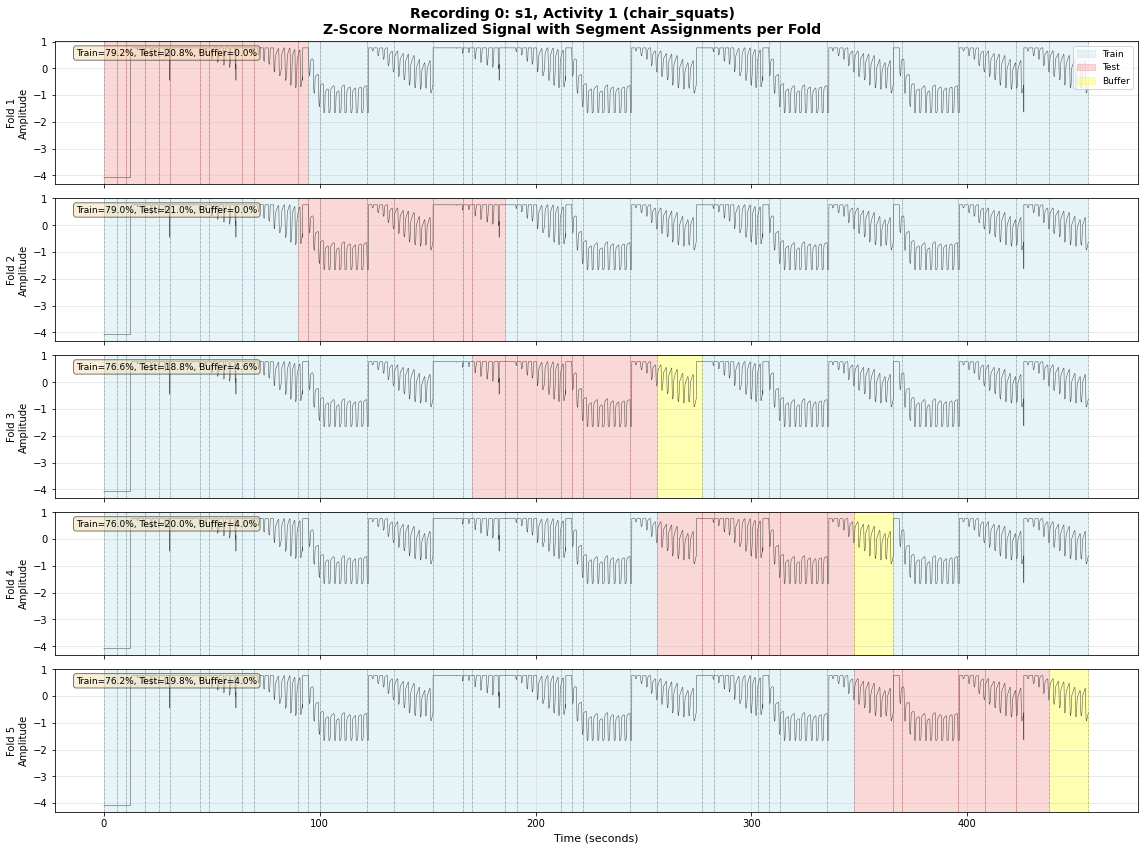


✓ Saved visualization for recording 0


In [7]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# Select a recording to visualize (pick one with interesting segments)
rec_id_to_plot = 0  # Change this to visualize different recordings

# Get recording and its segments
recording = raw_recordings[rec_id_to_plot]
recording_segments = segments_by_recording[rec_id_to_plot]
recording_folds = fold_info_df[fold_info_df['recording_id'] == rec_id_to_plot]

# Get normalized signal (just plot 1-2 channels for clarity)
signal = recording['data']  # Already normalized
channel_to_plot = 0  # Plot channel 1

# Time axis
time_axis = np.arange(signal.shape[0]) / FS

# Create figure with 5 subplots (one per fold)
fig, axes = plt.subplots(5, 1, figsize=(16, 12), sharex=True)
fig.suptitle(f'Recording {rec_id_to_plot}: {recording["subject"]}, Activity {recording["activity_id"]} ({recording["activity_label"]})\n'
             f'Z-Score Normalized Signal with Segment Assignments per Fold', 
             fontsize=14, fontweight='bold')

colors = {'train': 'lightblue', 'test': 'lightcoral', 'buffer': 'yellow'}

for fold_idx, fold in enumerate(range(1, N_FOLDS + 1)):
    ax = axes[fold_idx]
    
    # Plot the signal
    ax.plot(time_axis, signal[:, channel_to_plot], 'k-', linewidth=0.5, alpha=0.7)
    ax.set_ylabel(f'Fold {fold}\nAmplitude', fontsize=10)
    ax.grid(True, alpha=0.3)
    
    # Get fold info for this recording
    fold_info = recording_folds[recording_folds['fold'] == fold].iloc[0]
    
    # Color-code segments based on their assignment
    for seg_idx, segment in enumerate(recording_segments):
        seg_start_time = segment['start_time_in_recording']
        seg_end_time = seg_start_time + segment['duration_sec']
        
        # Determine segment role
        if seg_idx in fold_info['test_segment_indices']:
            color = colors['test']
            label = 'Test'
        elif seg_idx in fold_info['train_segment_indices']:
            color = colors['train']
            label = 'Train'
        elif seg_idx in fold_info['buffer_segment_indices']:
            color = colors['buffer']
            label = 'Buffer'
        else:
            continue
        
        # Shade the segment region
        ax.axvspan(seg_start_time, seg_end_time, alpha=0.3, color=color)
        
        # Draw segment boundary
        ax.axvline(seg_start_time, color='gray', linestyle='--', linewidth=0.8, alpha=0.5)
    
    # Draw final boundary
    ax.axvline(recording['duration_sec'], color='gray', linestyle='--', linewidth=0.8, alpha=0.5)
    
    # Add text showing percentages
    test_pct = fold_info['test_pct']
    train_pct = fold_info['train_pct']
    buffer_pct = fold_info['buffer_pct']
    ax.text(0.02, 0.95, f'Train={train_pct:.1f}%, Test={test_pct:.1f}%, Buffer={buffer_pct:.1f}%',
            transform=ax.transAxes, fontsize=9, verticalalignment='top',
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

axes[-1].set_xlabel('Time (seconds)', fontsize=11)

# Create legend
train_patch = mpatches.Patch(color=colors['train'], alpha=0.3, label='Train')
test_patch = mpatches.Patch(color=colors['test'], alpha=0.3, label='Test')
buffer_patch = mpatches.Patch(color=colors['buffer'], alpha=0.3, label='Buffer')
axes[0].legend(handles=[train_patch, test_patch, buffer_patch], loc='upper right', fontsize=9)

plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, f'segments_visualization_rec{rec_id_to_plot}.png'), dpi=150, bbox_inches='tight')
plt.show()

print(f"\n✓ Saved visualization for recording {rec_id_to_plot}")


GENERATING VISUALIZATION (ALL 16 CHANNELS)
Found 6 Activity 4 recordings: [3, 13, 23, 33, 41, 47]
Plotting recording 33

✓ Saved visualization: /home/jupyter-yin10/EEG_HAR/Pipeline_experiments/results/eegnet_zscore_75overlap/all_channels_visualization_rec33_activity4.png


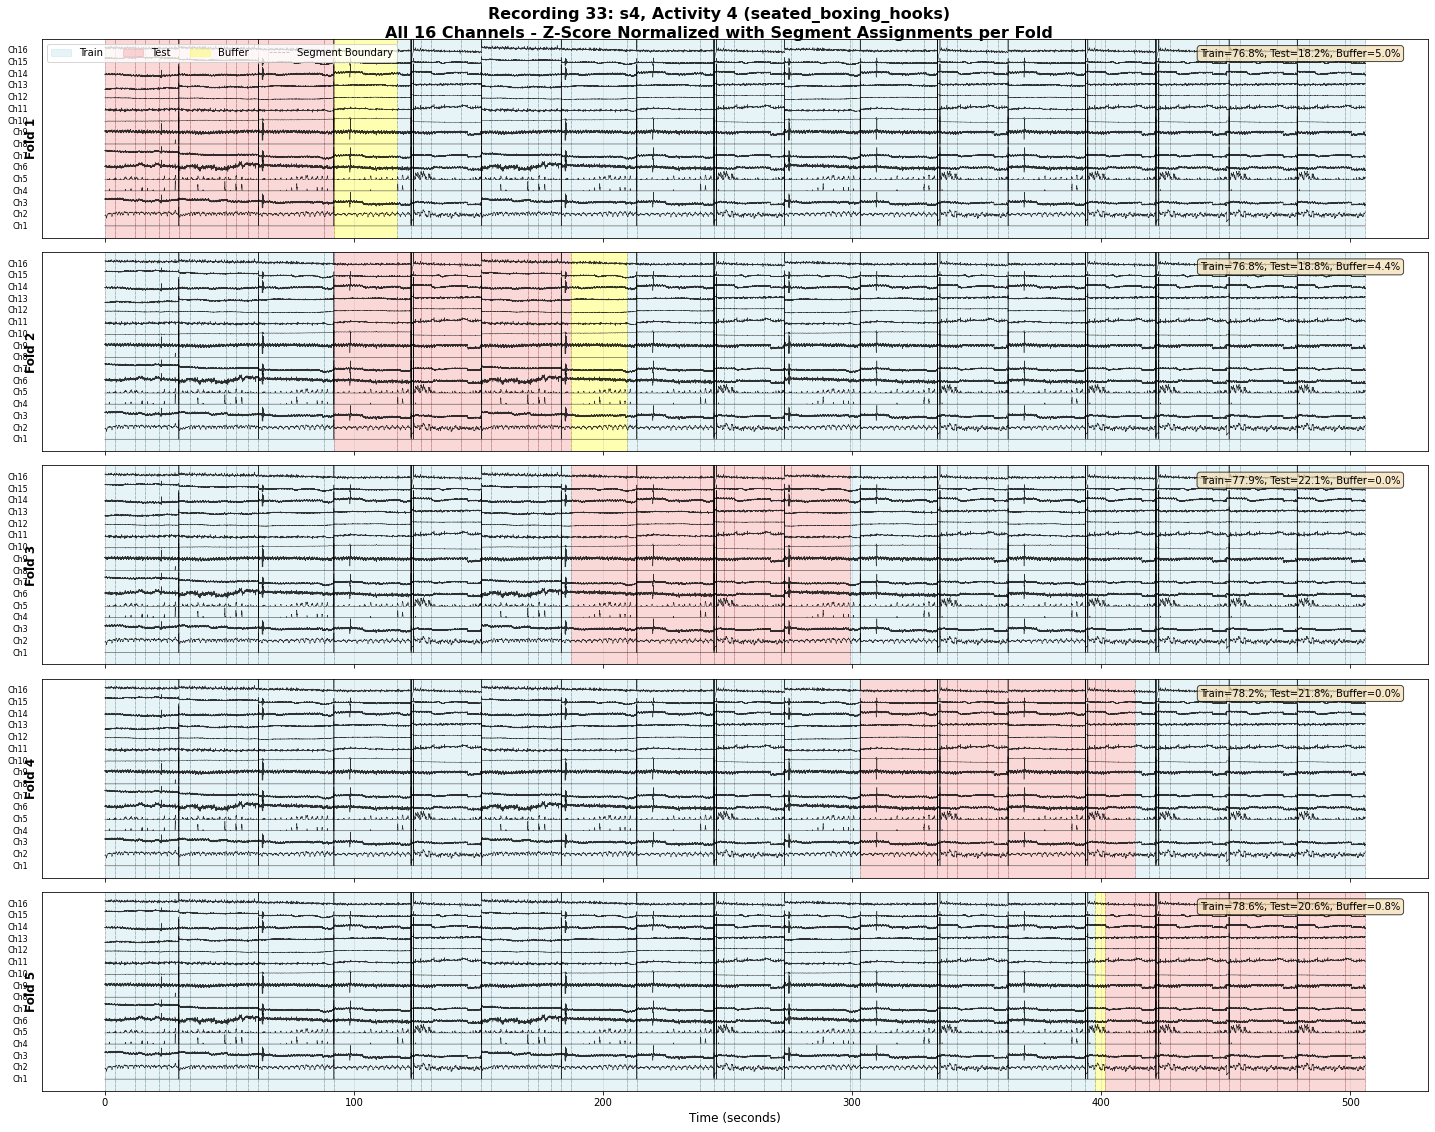

In [9]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# =====================================================
# VISUALIZATION: ALL 16 CHANNELS FOR ACTIVITY 4 ACROSS 5 FOLDS
# =====================================================

print(f"\n" + "="*70)
print("GENERATING VISUALIZATION (ALL 16 CHANNELS)")
print("="*70)

# Find all recordings with Activity 4
activity_4_recordings = [i for i, rec in enumerate(raw_recordings) if rec['activity_id'] == 4]

if len(activity_4_recordings) == 0:
    print("No Activity 4 recordings found!")
else:
    print(f"Found {len(activity_4_recordings)} Activity 4 recordings: {activity_4_recordings}")
    
    # Select recording (change index or filter by subject)
    rec_id_to_plot = activity_4_recordings[3]  # Change [0] to [1], [2], etc.
    print(f"Plotting recording {rec_id_to_plot}")
    
    # Get recording and its segments
    recording = raw_recordings[rec_id_to_plot]
    recording_segments = segments_by_recording[rec_id_to_plot]
    recording_folds = fold_info_df[fold_info_df['recording_id'] == rec_id_to_plot]
    
    # Get normalized signal (all 16 channels)
    signal = recording['data']  # Shape: (n_samples, 16)
    
    # Time axis
    time_axis = np.arange(signal.shape[0]) / FS
    
    # Create figure with 5 subplots (one per fold)
    fig, axes = plt.subplots(5, 1, figsize=(20, 16), sharex=True)
    fig.suptitle(f'Recording {rec_id_to_plot}: {recording["subject"]}, Activity {recording["activity_id"]} ({recording["activity_label"]})\n'
                 f'All 16 Channels - Z-Score Normalized with Segment Assignments per Fold', 
                 fontsize=16, fontweight='bold')
    
    colors = {'train': 'lightblue', 'test': 'lightcoral', 'buffer': 'yellow'}
    
    # Calculate offsets for stacking channels
    channel_offset = 8  # Vertical spacing between channels
    
    for fold_idx, fold in enumerate(range(1, N_FOLDS + 1)):
        ax = axes[fold_idx]
        
        # Get fold info for this recording
        fold_info = recording_folds[recording_folds['fold'] == fold].iloc[0]
        
        # First, color-code the background by segments
        for seg_idx, segment in enumerate(recording_segments):
            seg_start_time = segment['start_time_in_recording']
            seg_end_time = seg_start_time + segment['duration_sec']
            
            # Determine segment role
            if seg_idx in fold_info['test_segment_indices']:
                color = colors['test']
            elif seg_idx in fold_info['train_segment_indices']:
                color = colors['train']
            elif seg_idx in fold_info['buffer_segment_indices']:
                color = colors['buffer']
            else:
                continue
            
            # Shade the entire vertical span for this segment
            ax.axvspan(seg_start_time, seg_end_time, alpha=0.3, color=color, zorder=0)
            
            # Draw segment boundary
            ax.axvline(seg_start_time, color='gray', linestyle='--', linewidth=0.8, alpha=0.5, zorder=1)
        
        # Draw final boundary
        ax.axvline(recording['duration_sec'], color='gray', linestyle='--', linewidth=0.8, alpha=0.5, zorder=1)
        
        # Plot all 16 channels with vertical offsets
        for ch_idx in range(16):
            offset = ch_idx * channel_offset
            ax.plot(time_axis, signal[:, ch_idx] + offset, 'k-', linewidth=0.5, alpha=0.8, zorder=2)
            
            # Label each channel on the left
            ax.text(-0.01, offset, f'Ch{ch_idx+1}', 
                   transform=ax.get_yaxis_transform(), 
                   fontsize=8, verticalalignment='center', 
                   horizontalalignment='right')
        
        ax.set_ylabel(f'Fold {fold}', fontsize=12, fontweight='bold')
        ax.set_ylim(-channel_offset, 16 * channel_offset)
        ax.grid(True, alpha=0.3, axis='x')
        
        # Remove y-axis ticks (they're meaningless with stacked channels)
        ax.set_yticks([])
        
        # Add text showing percentages
        test_pct = fold_info['test_pct']
        train_pct = fold_info['train_pct']
        buffer_pct = fold_info['buffer_pct']
        ax.text(0.98, 0.95, f'Train={train_pct:.1f}%, Test={test_pct:.1f}%, Buffer={buffer_pct:.1f}%',
                transform=ax.transAxes, fontsize=10, verticalalignment='top',
                horizontalalignment='right',
                bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.7))
    
    axes[-1].set_xlabel('Time (seconds)', fontsize=12)
    
    # Create legend
    train_patch = mpatches.Patch(color=colors['train'], alpha=0.3, label='Train')
    test_patch = mpatches.Patch(color=colors['test'], alpha=0.3, label='Test')
    buffer_patch = mpatches.Patch(color=colors['buffer'], alpha=0.3, label='Buffer')
    segment_line = plt.Line2D([0], [0], color='gray', linestyle='--', linewidth=0.8, alpha=0.5, label='Segment Boundary')
    axes[0].legend(handles=[train_patch, test_patch, buffer_patch, segment_line], 
                  loc='upper left', fontsize=10, ncol=4)
    
    plt.tight_layout()
    
    # Save figure
    viz_file = os.path.join(OUTPUT_DIR, f'all_channels_visualization_rec{rec_id_to_plot}_activity4.png')
    plt.savefig(viz_file, dpi=150, bbox_inches='tight')
    print(f"\n✓ Saved visualization: {viz_file}")
    
    plt.show()